#Aula 01

In [ ]:
import pandas as pd

uri = "https://gist.githubusercontent.com/guilhermesilveira/e99a526b2e7ccc6c3b70f53db43a87d2/raw/1605fc74aa778066bf2e6695e24d53cf65f2f447/machine-learning-carros-simulacao.csv"

dados = pd.read_csv(uri).drop(columns=["Unnamed: 0"], axis=1)

dados.head()

,preco,vendido,idade_do_modelo,km_por_ano
0,30941.02,1,18,35085.22134
1,40557.96,1,20,12622.05362
2,89627.50,0,12,11440.79806
3,95276.14,0,3,43167.32682
4,117384.68,1,4,12770.11290


## Revisão do Curso Passado

In [ ]:
#Ordenando os dados para "dificultar a análise"
dados_azar = dados.sort_values("vendido", ascending=True)
x_azar = dados_azar[["preco", "idade_do_modelo","km_por_ano"]]
y_azar = dados_azar["vendido"]
dados_azar.head()

,preco,vendido,idade_do_modelo,km_por_ano
4999,74023.29,0,12,24812.80412
5322,84843.49,0,13,23095.63834
5319,83100.27,0,19,36240.72746
5316,87932.13,0,16,32249.56426
5315,77937.01,0,15,28414.50704


In [ ]:
#Algoritmo de Base
from sklearn.model_selection import cross_validate
from sklearn.dummy import DummyClassifier
import numpy as np

SEED = 301
np.random.seed(SEED)

modelo = DummyClassifier()
results = cross_validate(modelo, x_azar, y_azar, cv = 10, return_train_score=False)
media = results['test_score'].mean()
desvio_padrao = results['test_score'].std()
print("Accuracy com dummy stratified, 10 = [%.2f, %.2f]" % ((media - 2 * desvio_padrao)*100, (media + 2 * desvio_padrao) * 100))

Accuracy com dummy stratified, 10 = [49.79, 53.45]


/usr/local/lib/python3.7/dist-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)


In [ ]:
#Rodando Árvore de Decisão
from sklearn.model_selection import cross_validate
from sklearn.tree import DecisionTreeClassifier

SEED = 301
np.random.seed(SEED)

modelo = DecisionTreeClassifier(max_depth=2)
results = cross_validate(modelo, x_azar, y_azar, cv = 10, return_train_score=False)
media = results['test_score'].mean()
desvio_padrao = results['test_score'].std()
print("Accuracy com cross validation, 10 = [%.2f, %.2f]" % ((media - 2 * desvio_padrao)*100, (media + 2 * desvio_padrao) * 100))

Accuracy com cross validation, 10 = [73.83, 77.73]


In [ ]:
# gerando dados aleatórios de modelo de carro para simulação de agrupamento ao usar nosso estimador

np.random.seed(SEED)
dados['modelo'] = dados.idade_do_modelo + np.random.randint(-2, 3, size=10000)
dados.modelo = dados.modelo + abs(dados.modelo.min()) + 1
dados.head()

,preco,vendido,idade_do_modelo,km_por_ano,modelo
0,30941.02,1,18,35085.22134,18
1,40557.96,1,20,12622.05362,24
2,89627.50,0,12,11440.79806,14
3,95276.14,0,3,43167.32682,6
4,117384.68,1,4,12770.11290,5


In [ ]:
def imprime_resultados(results):
  media = results['test_score'].mean() * 100
  desvio = results['test_score'].std() * 100
  print("Accuracy médio %.2f" % media)
  print("Intervalo [%.2f, %.2f]" % (media - 2 * desvio, media + 2 * desvio))

In [ ]:
# GroupKFold em um pipeline com StandardScaler e SVC

from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GroupKFold

SEED = 301
np.random.seed(SEED)

scaler = StandardScaler()
modelo = SVC()

pipeline = Pipeline([('transformacao',scaler), ('estimador',modelo)])

cv = GroupKFold(n_splits = 10)
results = cross_validate(pipeline, x_azar, y_azar, cv = cv, groups = dados.modelo, return_train_score=False)
imprime_resultados(results)

Accuracy médio 76.68
Intervalo [74.28, 79.08]


In [ ]:
# GroupKFold para analisar como o modelo se comporta com novos grupos

from sklearn.model_selection import GroupKFold

SEED = 301
np.random.seed(SEED)

cv = GroupKFold(n_splits = 10)
modelo = DecisionTreeClassifier(max_depth=2)
results = cross_validate(modelo, x_azar, y_azar, cv = cv, groups = dados.modelo, return_train_score=False)
imprime_resultados(results)

Accuracy médio 75.78
Intervalo [73.67, 77.90]


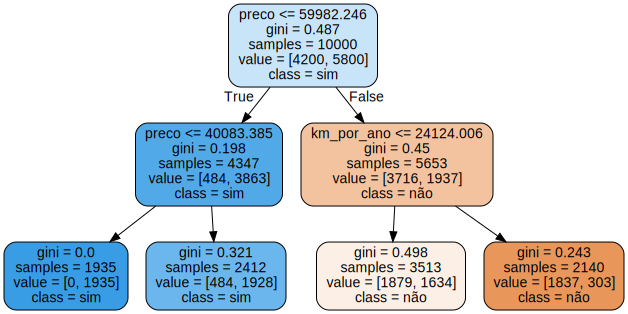

In [ ]:
from sklearn.tree import export_graphviz
import graphviz

modelo.fit(x_azar, y_azar)
features = x_azar.columns
dot_data = export_graphviz(modelo, out_file=None, filled=True, rounded=True, 
                class_names=["não", "sim"], 
                feature_names =  features)

graph = graphviz.Source(dot_data)
graph

## Validando Complexidade da Árvore

Parâmetros que são definidos antes do treino são chamados de hiperparâmetros, e são diferentes de valores internos do modelo que vão sendo alterados de acordo com o que o modelo está aprendendo.

In [ ]:
def roda_arvore_decisao(max_depth):
  SEED = 301
  np.random.seed(SEED)

  cv = GroupKFold(n_splits = 10)
  modelo = DecisionTreeClassifier(max_depth=max_depth)
  results = cross_validate(modelo, x_azar, y_azar, cv = cv, groups = dados.modelo,return_train_score=True)
  print("Arvore max_depth = %d, treino = %.2f, teste = %.2f," % (max_depth, results['train_score'].mean() * 100, results['test_score'].mean() * 100))

for i in range(1,33):
  roda_arvore_decisao(i)

Arvore max_depth = 1, treino = 75.79, teste = 75.78,
Arvore max_depth = 2, treino = 75.79, teste = 75.78,
Arvore max_depth = 3, treino = 78.75, teste = 78.67,
Arvore max_depth = 4, treino = 78.79, teste = 78.63,
Arvore max_depth = 5, treino = 78.94, teste = 78.56,
Arvore max_depth = 6, treino = 79.17, teste = 78.12,
Arvore max_depth = 7, treino = 79.50, teste = 77.96,
Arvore max_depth = 8, treino = 79.89, teste = 77.86,
Arvore max_depth = 9, treino = 80.46, teste = 77.38,
Arvore max_depth = 10, treino = 81.16, teste = 77.19,
Arvore max_depth = 11, treino = 82.03, teste = 76.97,
Arvore max_depth = 12, treino = 82.89, teste = 76.49,
Arvore max_depth = 13, treino = 83.95, teste = 75.81,
Arvore max_depth = 14, treino = 85.03, teste = 75.66,
Arvore max_depth = 15, treino = 86.14, teste = 75.16,
Arvore max_depth = 16, treino = 87.19, teste = 75.11,
Arvore max_depth = 17, treino = 88.31, teste = 74.74,
Arvore max_depth = 18, treino = 89.26, teste = 74.33,
Arvore max_depth = 19, treino = 90.32

In [ ]:
def roda_arvore_de_decisao(max_depth):
  SEED = 301
  np.random.seed(SEED)

  cv = GroupKFold(n_splits = 10)
  modelo = DecisionTreeClassifier(max_depth=max_depth)
  results = cross_validate(modelo, x_azar, y_azar, cv = cv, groups = dados.modelo, return_train_score=True)
  #print("Arvore max_depth = %d, treino = %.2f, teste = %.2f," % (max_depth, results['train_score'].mean() * 100, results['test_score'].mean() * 100))
  tabela = [max_depth,results['train_score'].mean() * 100,results['test_score'].mean() * 100]
  return tabela

resultados = [roda_arvore_de_decisao(i) for i in range (1, 33)]      
resultados = pd.DataFrame(resultados,columns=['max_depth',"train","test"])

In [ ]:
resultados

,max_depth,train,test
0,1,75.791169,75.784219
1,2,75.791169,75.784219
2,3,78.750993,78.672633
3,4,78.787628,78.632803
4,5,78.941007,78.555912
5,6,79.170115,78.123266
6,7,79.496806,77.963185
7,8,79.887810,77.857951
8,9,80.459009,77.376956
9,10,81.158994,77.194204


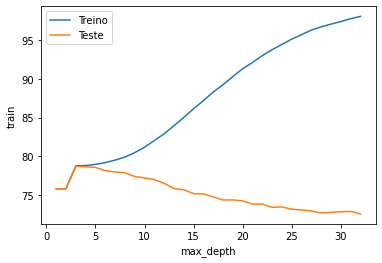

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.lineplot(x = "max_depth",y='train',data=resultados)
sns.lineplot(x = "max_depth",y='test',data=resultados)
plt.legend(['Treino','Teste'])

Em determinado momento, o algoritmo começa a ficar tão exato para o modelo que deixa de ser adequado para os testes, com a média sendo cada vez menor.

In [ ]:
resultados.sort_values("test",ascending=False).head()

,max_depth,train,test
2,3,78.750993,78.672633
3,4,78.787628,78.632803
4,5,78.941007,78.555912
5,6,79.170115,78.123266
6,7,79.496806,77.963185


#Aula 02

Vamos explorar hiperparâmetros em duas dimensões

In [ ]:
def roda_arvore_de_decisao(max_depth,min_samples_leaf):
  SEED = 301
  np.random.seed(SEED)

  cv = GroupKFold(n_splits = 10)
  modelo = DecisionTreeClassifier(max_depth=max_depth,min_samples_leaf=min_samples_leaf)
  results = cross_validate(modelo, x_azar, y_azar, cv = cv, groups = dados.modelo, return_train_score=True)
  print("Arvore max_depth = %d, min_samples_leaf = %.2f, treino = %.2f, teste = %.2f," % (max_depth, min_samples_leaf, results['train_score'].mean() * 100, results['test_score'].mean() * 100))
  tabela = [max_depth, min_samples_leaf,results['train_score'].mean() * 100,results['test_score'].mean() * 100]
  return tabela

def busca():
  resultados = []
  for max_depth in range(1,33):
    for min_samples_leaf in [32,64,128,256]:
      tabela = roda_arvore_de_decisao(max_depth,min_samples_leaf)
      resultados.append(tabela)
  resultados = pd.DataFrame(resultados,columns=['max_depth',"min_samples_leaf","train","test"])
  return resultados


resultados = busca()
resultados.head()

Arvore max_depth = 1, min_samples_leaf = 32.00, treino = 75.79, teste = 75.78,
Arvore max_depth = 1, min_samples_leaf = 64.00, treino = 75.79, teste = 75.78,
Arvore max_depth = 1, min_samples_leaf = 128.00, treino = 75.79, teste = 75.78,
Arvore max_depth = 1, min_samples_leaf = 256.00, treino = 75.79, teste = 75.78,
Arvore max_depth = 2, min_samples_leaf = 32.00, treino = 75.79, teste = 75.78,
Arvore max_depth = 2, min_samples_leaf = 64.00, treino = 75.79, teste = 75.78,
Arvore max_depth = 2, min_samples_leaf = 128.00, treino = 75.79, teste = 75.78,
Arvore max_depth = 2, min_samples_leaf = 256.00, treino = 75.79, teste = 75.78,
Arvore max_depth = 3, min_samples_leaf = 32.00, treino = 78.75, teste = 78.67,
Arvore max_depth = 3, min_samples_leaf = 64.00, treino = 78.75, teste = 78.67,
Arvore max_depth = 3, min_samples_leaf = 128.00, treino = 78.75, teste = 78.67,
Arvore max_depth = 3, min_samples_leaf = 256.00, treino = 78.75, teste = 78.67,
Arvore max_depth = 4, min_samples_leaf = 32.00

,max_depth,min_samples_leaf,train,test
0,1,32,75.791169,75.784219
1,1,64,75.791169,75.784219
2,1,128,75.791169,75.784219
3,1,256,75.791169,75.784219
4,2,32,75.791169,75.784219


In [ ]:
resultados.sort_values("test",ascending=False)

,max_depth,min_samples_leaf,train,test
15,4,256,78.750993,78.672633
12,4,32,78.750993,78.672633
14,4,128,78.750993,78.672633
13,4,64,78.750993,78.672633
8,3,32,78.750993,78.672633
...,...,...,...,...
5,2,64,75.791169,75.784219
4,2,32,75.791169,75.784219
3,1,256,75.791169,75.784219
2,1,128,75.791169,75.784219


In [ ]:
corr = resultados.corr()

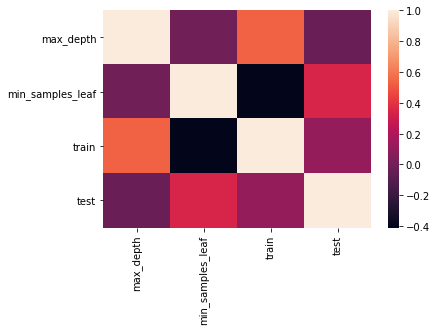

In [ ]:
sns.heatmap(corr)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe286c71f50>,
      dtype=object)

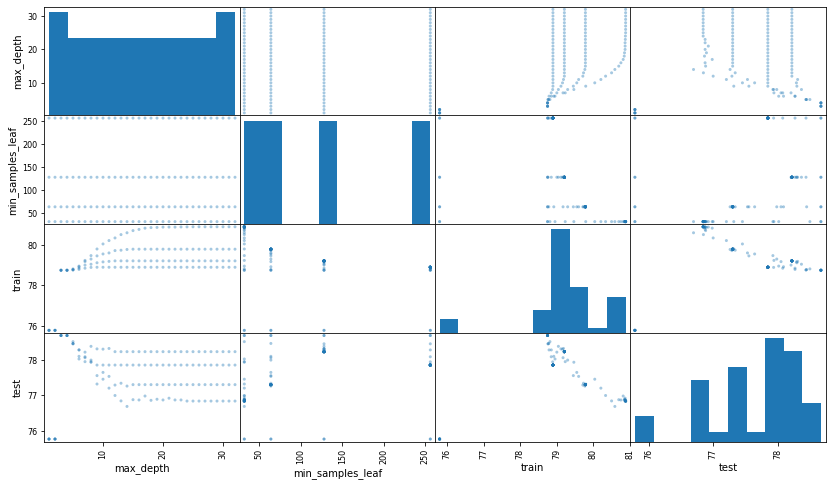

In [ ]:
from pandas.plotting import scatter_matrix 

scatter_matrix(resultados,figsize=[14,8],alpha=0.4)

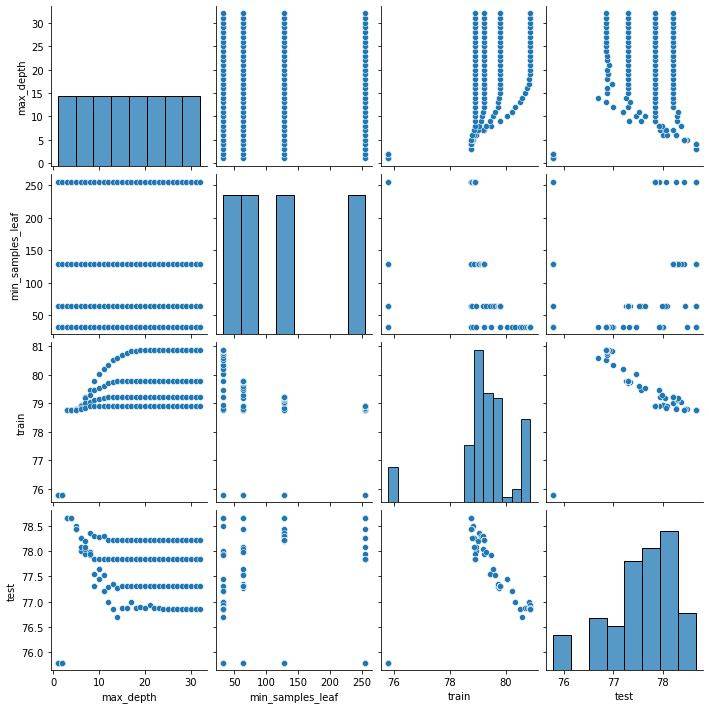

In [ ]:
sns.pairplot(resultados)

Arvore max_depth = 1, min_samples_leaf = 128.00, treino = 75.79, teste = 75.78,
Arvore max_depth = 1, min_samples_leaf = 192.00, treino = 75.79, teste = 75.78,
Arvore max_depth = 1, min_samples_leaf = 256.00, treino = 75.79, teste = 75.78,
Arvore max_depth = 1, min_samples_leaf = 512.00, treino = 75.79, teste = 75.78,
Arvore max_depth = 2, min_samples_leaf = 128.00, treino = 75.79, teste = 75.78,
Arvore max_depth = 2, min_samples_leaf = 192.00, treino = 75.79, teste = 75.78,
Arvore max_depth = 2, min_samples_leaf = 256.00, treino = 75.79, teste = 75.78,
Arvore max_depth = 2, min_samples_leaf = 512.00, treino = 75.79, teste = 75.78,
Arvore max_depth = 3, min_samples_leaf = 128.00, treino = 78.75, teste = 78.67,
Arvore max_depth = 3, min_samples_leaf = 192.00, treino = 78.75, teste = 78.67,
Arvore max_depth = 3, min_samples_leaf = 256.00, treino = 78.75, teste = 78.67,
Arvore max_depth = 3, min_samples_leaf = 512.00, treino = 77.53, teste = 77.50,
Arvore max_depth = 4, min_samples_leaf =

,max_depth,min_samples_leaf,train,test
13,4,192,78.750993,78.672633
8,3,128,78.750993,78.672633
9,3,192,78.750993,78.672633
10,3,256,78.750993,78.672633
14,4,256,78.750993,78.672633


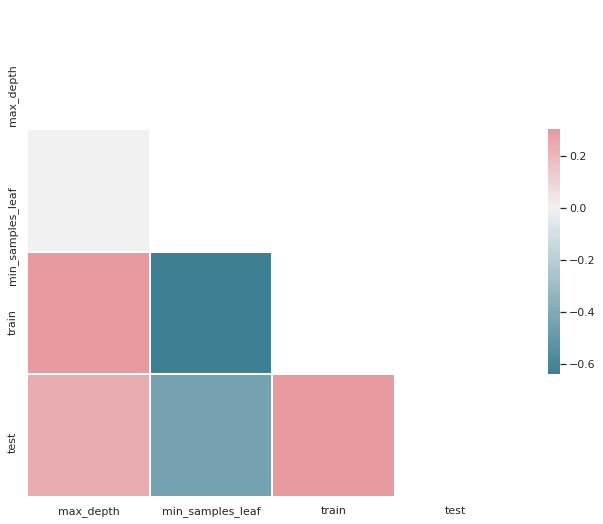

In [ ]:

def busca():
  resultados = []
  for max_depth in range(1,33):
    for min_samples_leaf in [128, 192, 256, 512]:
      tabela = roda_arvore_de_decisao(max_depth, min_samples_leaf)
      resultados.append(tabela)
  resultados = pd.DataFrame(resultados, columns= ["max_depth","min_samples_leaf","train","test"])
  return resultados

resultados = busca()
resultados.head()

corr = resultados.corr()

sns.set(style="white")

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

resultados.sort_values("test", ascending=False).head()

# Aula 03

In [ ]:
def roda_arvore_de_decisao(max_depth,min_samples_leaf,min_samples_split):
  SEED = 301
  np.random.seed(SEED)

  cv = GroupKFold(n_splits = 10)
  modelo = DecisionTreeClassifier(max_depth=max_depth,min_samples_leaf=min_samples_leaf,min_samples_split=min_samples_split)
  results = cross_validate(modelo, x_azar, y_azar, cv = cv, groups = dados.modelo, return_train_score=True)
  #print("Arvore max_depth = %d, min_samples_leaf = %.2f, min_samples_split = %.d, treino = %.2f, teste = %.2f," % (max_depth, min_samples_leaf, min_samples_split, results['train_score'].mean() * 100, results['test_score'].mean() * 100))
  tabela = [max_depth,min_samples_leaf,min_samples_split,results['train_score'].mean() * 100,results['test_score'].mean() * 100]
  return tabela

def busca():
  resultados = []
  for max_depth in range(1,33):
    for min_samples_leaf in [32,64,128,256]:
      for min_samples_split in [32,64,128,256]:
        tabela = roda_arvore_de_decisao(max_depth,min_samples_leaf,min_samples_split)
        resultados.append(tabela)
  resultados = pd.DataFrame(resultados,columns=['max_depth',"min_samples_leaf","min_samples_split","train","test"])
  return resultados


resultados = busca()
resultados.head()

,max_depth,min_samples_leaf,min_samples_split,train,test
0,1,32,32,75.791169,75.784219
1,1,32,64,75.791169,75.784219
2,1,32,128,75.791169,75.784219
3,1,32,256,75.791169,75.784219
4,1,64,32,75.791169,75.784219


,max_depth,min_samples_leaf,min_samples_split,train,test
63,4,256,256,78.750993,78.672633
48,4,32,32,78.750993,78.672633
34,3,32,128,78.750993,78.672633
35,3,32,256,78.750993,78.672633
36,3,64,32,78.750993,78.672633


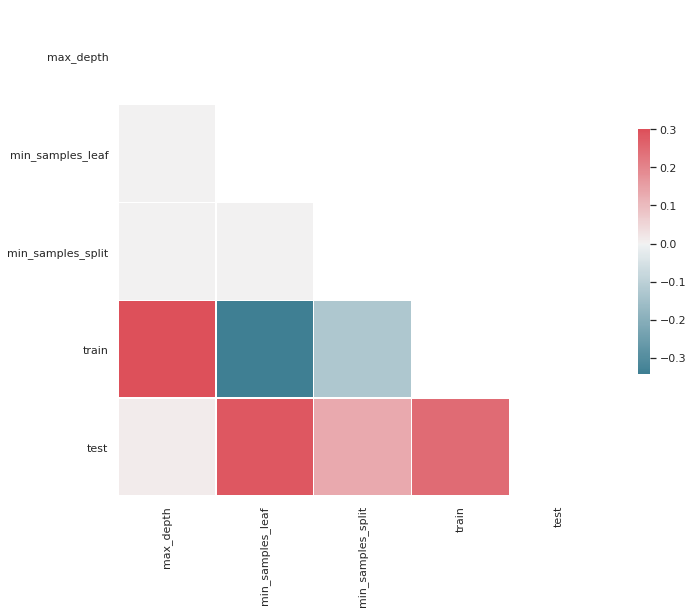

In [ ]:
corr = resultados.corr()

sns.set(style="white")

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

resultados.sort_values("test", ascending=False).head()

In [ ]:
def roda_arvore_de_decisao(max_depth,min_samples_leaf,min_samples_split):
  SEED = 301
  np.random.seed(SEED)

  cv = GroupKFold(n_splits = 10)
  modelo = DecisionTreeClassifier(max_depth=max_depth,min_samples_leaf=min_samples_leaf,min_samples_split=min_samples_split)
  results = cross_validate(modelo, x_azar, y_azar, cv = cv, groups = dados.modelo, return_train_score=True)
  fit_time = results['fit_time'].mean()
  score_time = results['score_time'].mean()
  #print("Arvore max_depth = %d, min_samples_leaf = %.2f, min_samples_split = %.d, treino = %.2f, teste = %.2f," % (max_depth, min_samples_leaf, min_samples_split, results['train_score'].mean() * 100, results['test_score'].mean() * 100))
  tabela = [max_depth,min_samples_leaf,min_samples_split,results['train_score'].mean() * 100,results['test_score'].mean() * 100,fit_time, score_time]
  return tabela

def busca():
  resultados = []
  for max_depth in range(1,33):
    for min_samples_leaf in [32,64,128,256]:
      for min_samples_split in [32,64,128,256]:
        tabela = roda_arvore_de_decisao(max_depth,min_samples_leaf,min_samples_split)
        resultados.append(tabela)
  resultados = pd.DataFrame(resultados,columns=['max_depth',"min_samples_leaf","min_samples_split","train","test","fit_time","score_time"])
  return resultados


resultados = busca()
resultados.head()

,max_depth,min_samples_leaf,min_samples_split,train,test,fit_time,score_time
0,1,32,32,75.791169,75.784219,0.005345,0.001138
1,1,32,64,75.791169,75.784219,0.005376,0.001195
2,1,32,128,75.791169,75.784219,0.005635,0.001377
3,1,32,256,75.791169,75.784219,0.005558,0.001296
4,1,64,32,75.791169,75.784219,0.005820,0.001443


,max_depth,min_samples_leaf,min_samples_split,train,test,fit_time,score_time
63,4,256,256,78.750993,78.672633,0.012360,0.001477
48,4,32,32,78.750993,78.672633,0.012880,0.001525
34,3,32,128,78.750993,78.672633,0.010478,0.001389
35,3,32,256,78.750993,78.672633,0.010621,0.001483
36,3,64,32,78.750993,78.672633,0.010326,0.001396


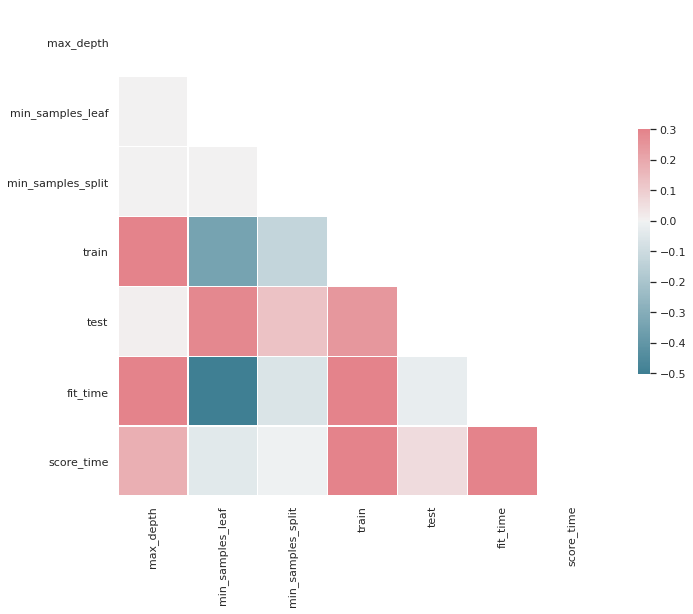

In [ ]:
corr = resultados.corr()

sns.set(style="white")

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

resultados.sort_values("test", ascending=False).head()

#Aula 04

O GridSearch do cross validation faz uma busca dos melhores hiperparâmetros.

In [ ]:
from sklearn.model_selection import GridSearchCV

SEED = 301

np.random.seed(SEED)

espaco_de_parametros = {
    "max_depth" : [3,5],
    "min_samples_split" : [32,64,128],
    "min_samples_leaf" : [32,64,128],
    "criterion" : ['gini','entropy']
}

busca = GridSearchCV(DecisionTreeClassifier(),
                     espaco_de_parametros,
                     cv = GroupKFold(n_splits=10))

busca.fit(x_azar,y_azar,groups=dados.modelo)

resultados = pd.DataFrame(busca.cv_results_)
resultados.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.010940,0.000945,0.001460,0.000097,gini,3,32,32,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.804757,0.793667,0.793313,0.78408,0.783181,0.797809,0.762866,0.781818,0.77551,0.790262,0.786726,0.011361,1
1,0.011793,0.001626,0.001577,0.000132,gini,3,32,64,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.804757,0.793667,0.793313,0.78408,0.783181,0.797809,0.762866,0.781818,0.77551,0.790262,0.786726,0.011361,1
2,0.011014,0.000611,0.001460,0.000067,gini,3,32,128,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.804757,0.793667,0.793313,0.78408,0.783181,0.797809,0.762866,0.781818,0.77551,0.790262,0.786726,0.011361,1
3,0.011472,0.001766,0.001437,0.000065,gini,3,64,32,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.804757,0.793667,0.793313,0.78408,0.783181,0.797809,0.762866,0.781818,0.77551,0.790262,0.786726,0.011361,1
4,0.011137,0.000813,0.001472,0.000116,gini,3,64,64,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.804757,0.793667,0.793313,0.78408,0.783181,0.797809,0.762866,0.781818,0.77551,0.790262,0.786726,0.011361,1


In [ ]:
print(busca.best_params_)
print(busca.best_score_*100)

{'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 32, 'min_samples_split': 32}
78.67263337284332


In [ ]:
melhor = busca.best_estimator_
melhor

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=32, min_samples_split=32,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [ ]:
from sklearn.metrics import accuracy_score

predicoes = melhor.predict(x_azar)
accuracy = accuracy_score(predicoes,y_azar)
print("Accuracy: %.3f" % accuracy)

Accuracy: 0.787


# Aula 05

In [ ]:
from sklearn.metrics import accuracy_score

#Abordagem otimista

predicoes = melhor.predict(x_azar)
accuracy = accuracy_score(predicoes,y_azar)
print("Accuracy: %.3f" % accuracy)

Accuracy: 0.787


No caso de cross validation, com busca de hiper parâmetros, fazemos uma nova validação cruazada. Necessário realizar uma nested cross validation.

In [ ]:
from sklearn.model_selection import cross_val_score

cross_val_score(busca,x_azar,y_azar,cv=GroupKFold(n_splits=10),groups=dados.modelo)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: The 'groups' parameter should not be None.

  FitFailedWarning)


array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])

Pandas não suporta nested validation com group k fold por conta do bug (https://github.com/scikit-learn/scikit-learn/issues/7646)

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

SEED = 301

np.random.seed(SEED)

espaco_de_parametros = {
    "max_depth" : [3,5],
    "min_samples_split" : [32,64,128],
    "min_samples_leaf" : [32,64,128],
    "criterion" : ['gini','entropy']
}

busca = GridSearchCV(DecisionTreeClassifier(),
                     espaco_de_parametros,
                     cv = KFold(n_splits=5,shuffle=True))

busca.fit(x_azar,y_azar)

resultados = pd.DataFrame(busca.cv_results_)
resultados.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.010398,0.000662,0.001844,0.000370,gini,3,32,32,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.784,0.776,0.8025,0.793,0.7795,0.787,0.009618,1
1,0.010091,0.000421,0.001769,0.000292,gini,3,32,64,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.784,0.776,0.8025,0.793,0.7795,0.787,0.009618,1
2,0.010224,0.000946,0.001531,0.000032,gini,3,32,128,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.784,0.776,0.8025,0.793,0.7795,0.787,0.009618,1
3,0.009686,0.000245,0.001526,0.000021,gini,3,64,32,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.784,0.776,0.8025,0.793,0.7795,0.787,0.009618,1
4,0.009911,0.000384,0.001739,0.000180,gini,3,64,64,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.784,0.776,0.8025,0.793,0.7795,0.787,0.009618,1


In [ ]:
melhor = busca.best_estimator_
melhor

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=32, min_samples_split=32,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [ ]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(busca,x_azar,y_azar,cv=KFold(n_splits=5,shuffle=True))
scores

array([0.7895, 0.7825, 0.7905, 0.7715, 0.7995])

In [ ]:
def imprime_resultados(scores):
  media = scores.mean() * 100
  desvio = scores.std() * 100
  print("Accuracy médio %.2f" % media)
  print("Intervalo [%.2f, %.2f]" % (media - 2 * desvio, media + 2 * desvio))

In [ ]:
imprime_resultados(scores)

Accuracy médio 78.67
Intervalo [76.80, 80.54]


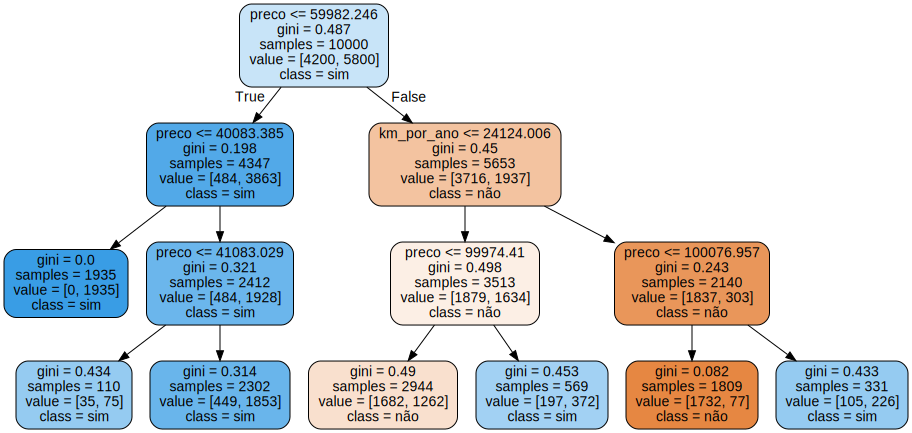

In [ ]:
from sklearn.tree import export_graphviz
import graphviz


dot_data = export_graphviz(melhor, out_file=None, filled=True, rounded=True, 
                class_names=["não", "sim"], 
                feature_names =  features)

graph = graphviz.Source(dot_data)
graph

#Aula 06

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold

SEED = 301

np.random.seed(SEED)

espaco_de_parametros = {
    "max_depth" : [3,5],
    "min_samples_split" : [32,64,128],
    "min_samples_leaf" : [32,64,128],
    "criterion" : ['gini','entropy']
}

busca = RandomizedSearchCV(DecisionTreeClassifier(),
                     espaco_de_parametros,
                     cv = KFold(n_splits=5,shuffle=True),
                     random_state=SEED,n_iter=16,
                     )

busca.fit(x_azar,y_azar)

resultados = pd.DataFrame(busca.cv_results_)
resultados.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_split,param_min_samples_leaf,param_max_depth,param_criterion,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.014195,0.001082,0.001679,0.000044,128,128,5,gini,"{'min_samples_split': 128, 'min_samples_leaf':...",0.784,0.769,0.7985,0.793,0.7730,0.7835,0.011278,13
1,0.010314,0.000974,0.001631,0.000093,64,32,3,gini,"{'min_samples_split': 64, 'min_samples_leaf': ...",0.784,0.776,0.8025,0.793,0.7795,0.7870,0.009618,1
2,0.010688,0.001654,0.001579,0.000091,64,128,3,gini,"{'min_samples_split': 64, 'min_samples_leaf': ...",0.784,0.776,0.8025,0.793,0.7795,0.7870,0.009618,1
3,0.020292,0.000724,0.001994,0.000642,32,64,5,entropy,"{'min_samples_split': 32, 'min_samples_leaf': ...",0.784,0.769,0.8005,0.793,0.7730,0.7839,0.011825,7
4,0.020380,0.001037,0.001651,0.000109,64,64,5,entropy,"{'min_samples_split': 64, 'min_samples_leaf': ...",0.784,0.769,0.8005,0.793,0.7730,0.7839,0.011825,7


In [ ]:
scores = cross_val_score(busca,x_azar,y_azar,cv=KFold(n_splits=5,shuffle=True))
scores
imprime_resultados(scores)

Accuracy médio 78.71
Intervalo [77.49, 79.93]


In [ ]:
melhor = busca.best_estimator_
print(melhor)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=32, min_samples_split=64,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')


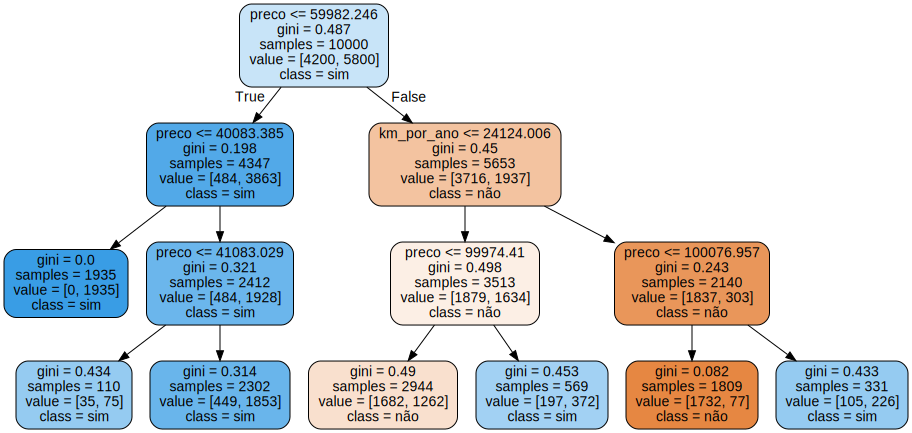

In [ ]:
dot_data = export_graphviz(melhor, out_file=None, filled=True, rounded=True, 
                class_names=["não", "sim"], 
                feature_names =  features)

graph = graphviz.Source(dot_data)
graph

# Aula 07

In [ ]:
from scipy.stats import randint

SEED = 301
np.random.seed(SEED)

espaco_de_parametros = {
    "max_depth" : [3,5,10,15,20,30,None],
    "min_samples_split" : randint(32,128),
    "min_samples_leaf" : randint(32,128),
    "criterion" : ['gini','entropy']
}

busca = RandomizedSearchCV(DecisionTreeClassifier(),
                     espaco_de_parametros,
                     cv = KFold(n_splits=5,shuffle=True),
                     random_state=SEED,n_iter=16,
                     )

busca.fit(x_azar,y_azar)

resultados = pd.DataFrame(busca.cv_results_)
resultados.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.014703,0.001432,0.001678,0.000176,entropy,3,71,100,"{'criterion': 'entropy', 'max_depth': 3, 'min_...",0.7840,0.7760,0.8025,0.7930,0.7795,0.7870,0.009618,1
1,0.017258,0.000440,0.001700,0.000144,gini,15,93,111,"{'criterion': 'gini', 'max_depth': 15, 'min_sa...",0.7740,0.7725,0.7830,0.7805,0.7725,0.7765,0.004393,14
2,0.017854,0.001087,0.001871,0.000285,gini,20,124,88,"{'criterion': 'gini', 'max_depth': 20, 'min_sa...",0.7705,0.7745,0.7990,0.7790,0.7735,0.7793,0.010221,8
3,0.021647,0.001809,0.002142,0.000601,gini,None,46,62,"{'criterion': 'gini', 'max_depth': None, 'min_...",0.7575,0.7730,0.7725,0.7835,0.7560,0.7685,0.010378,16
4,0.017137,0.000570,0.001708,0.000057,gini,15,126,84,"{'criterion': 'gini', 'max_depth': 15, 'min_sa...",0.7705,0.7735,0.7995,0.7790,0.7745,0.7794,0.010413,7


In [ ]:
scores = cross_val_score(busca,x_azar,y_azar,cv=KFold(n_splits=5,shuffle=True))
scores
imprime_resultados(scores)

Accuracy médio 78.71
Intervalo [77.49, 79.93]


In [ ]:
melhor = busca.best_estimator_
print(melhor)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=71, min_samples_split=100,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')


In [ ]:
resultados_ordenados_pela_media = resultados.sort_values("mean_test_score",ascending=False)

for indice, linha in resultados_ordenados_pela_media.iterrows():
  print("%.3f +-(%.3f) %s" %(linha.mean_test_score,linha.std_test_score*2,linha.params))
  

0.787 +-(0.019) {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 71, 'min_samples_split': 100}
0.784 +-(0.024) {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 73, 'min_samples_split': 72}
0.784 +-(0.024) {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 64, 'min_samples_split': 67}
0.781 +-(0.017) {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 108, 'min_samples_split': 110}
0.780 +-(0.019) {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 125, 'min_samples_split': 59}
0.780 +-(0.012) {'criterion': 'gini', 'max_depth': 15, 'min_samples_leaf': 103, 'min_samples_split': 96}
0.779 +-(0.021) {'criterion': 'gini', 'max_depth': 15, 'min_samples_leaf': 126, 'min_samples_split': 84}
0.779 +-(0.020) {'criterion': 'gini', 'max_depth': 20, 'min_samples_leaf': 124, 'min_samples_split': 88}
0.779 +-(0.009) {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 101, 'min_samples_split': 52}
0.779 +-(0.014) {'criterion': 'entropy', 'max_depth

## Explorando Melhor o RandomSearch

In [ ]:
from scipy.stats import randint

SEED = 123
np.random.seed(SEED)

espaco_de_parametros = {
    "max_depth" : [3,5,10,15,20,30,None],
    "min_samples_split" : randint(32,128),
    "min_samples_leaf" : randint(32,128),
    "criterion" : ['gini','entropy']
}

busca = RandomizedSearchCV(DecisionTreeClassifier(),
                     espaco_de_parametros,
                     cv = KFold(n_splits=5,shuffle=True),
                     random_state=SEED,n_iter=64,
                     )

busca.fit(x_azar,y_azar)

resultados = pd.DataFrame(busca.cv_results_)
resultados.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.018182,0.000975,0.001926,0.000228,gini,30,98,124,"{'criterion': 'gini', 'max_depth': 30, 'min_sa...",0.7655,0.7735,0.7710,0.7940,0.7605,0.7729,0.011469,58
1,0.020758,0.001190,0.002362,0.000626,gini,None,49,115,"{'criterion': 'gini', 'max_depth': None, 'min_...",0.7705,0.7655,0.7705,0.7965,0.7630,0.7732,0.012007,57
2,0.020747,0.002118,0.001895,0.000140,gini,15,89,118,"{'criterion': 'gini', 'max_depth': 15, 'min_sa...",0.7665,0.7740,0.7760,0.7955,0.7650,0.7754,0.010897,35
3,0.014613,0.000705,0.001789,0.000319,entropy,3,79,105,"{'criterion': 'entropy', 'max_depth': 3, 'min_...",0.7790,0.7910,0.7825,0.8000,0.7820,0.7869,0.007671,1
4,0.019774,0.001228,0.001654,0.000092,gini,None,57,115,"{'criterion': 'gini', 'max_depth': None, 'min_...",0.7730,0.7730,0.7765,0.7930,0.7585,0.7748,0.011012,43


In [ ]:
scores = cross_val_score(busca,x_azar,y_azar,cv=KFold(n_splits=5,shuffle=True))
scores
imprime_resultados(scores)

Accuracy médio 78.68
Intervalo [76.35, 81.01]


In [ ]:
resultados_ordenados_pela_media = resultados.sort_values("mean_test_score",ascending=False)

for indice, linha in resultados_ordenados_pela_media.iterrows():
  print("%.3f +-(%.3f) %s" %(linha.mean_test_score,linha.std_test_score*2,linha.params))

0.787 +-(0.015) {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 79, 'min_samples_split': 105}
0.787 +-(0.015) {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 92, 'min_samples_split': 41}
0.787 +-(0.015) {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 93, 'min_samples_split': 80}
0.787 +-(0.015) {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 119, 'min_samples_split': 95}
0.786 +-(0.014) {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 32, 'min_samples_split': 67}
0.785 +-(0.016) {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 35, 'min_samples_split': 43}
0.785 +-(0.016) {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 59, 'min_samples_split': 89}
0.785 +-(0.016) {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 80, 'min_samples_split': 88}
0.785 +-(0.016) {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 44, 'min_samples_split': 50}
0.785 +-(0.016) {'criterion': 'entropy', 'max_depth': 5,

In [ ]:
melhor = busca.best_estimator_
print(melhor)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=79, min_samples_split=105,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')


# Aula 08

In [ ]:
from sklearn.ensemble import RandomForestClassifier
import time

SEED = 301

np.random.seed(SEED)

espaco_de_parametros = {
    "n_estimators" : [10,100],
    "max_depth" : [3,5],
    "min_samples_split" : [32,64,128],
    "min_samples_leaf" : [32,64,128],
    "criterion" : ['gini','entropy'],
    "bootstrap" : [True,False]
}

tic = time.time()

busca = GridSearchCV(RandomForestClassifier(),
                     espaco_de_parametros,
                     cv = GroupKFold(n_splits=10))

busca.fit(x_azar,y_azar,groups=dados.modelo)
tac = time.time()

tempo_que_passou = tac - tic

print("Tempo %.2f segundos" % tempo_que_passou)

resultados = pd.DataFrame(busca.cv_results_)
resultados.head()

Tempo 495.61 segundos


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bootstrap,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.047555,0.002529,0.003735,0.000443,True,gini,3,32,32,10,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.777998,0.773238,0.777102,0.754229,0.728470,0.752988,0.753784,0.773737,0.717347,0.775281,0.758417,0.020306,142
1,0.458672,0.017315,0.018630,0.002178,True,gini,3,32,32,100,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.778989,0.782431,0.773050,0.784080,0.773050,0.786853,0.751766,0.774747,0.765306,0.768727,0.773900,0.009812,73
2,0.057612,0.033221,0.003338,0.000325,True,gini,3,32,64,10,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.778989,0.772217,0.752786,0.783085,0.772036,0.757968,0.712412,0.775758,0.761224,0.774345,0.764082,0.019487,128
3,0.455860,0.014005,0.018116,0.001709,True,gini,3,32,64,100,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.778989,0.782431,0.779129,0.784080,0.774063,0.775896,0.751766,0.774747,0.766327,0.773408,0.774084,0.008841,68
4,0.046828,0.002018,0.003433,0.000431,True,gini,3,32,128,10,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.780971,0.771195,0.752786,0.753234,0.748734,0.764940,0.752775,0.754545,0.767347,0.765918,0.761245,0.009848,134


In [ ]:
resultados_ordenados_pela_media = resultados.sort_values("mean_test_score",ascending=False)

for indice, linha in resultados_ordenados_pela_media[:5].iterrows():
  print("%.3f +-(%.3f) %s" %(linha.mean_test_score,linha.std_test_score*2,linha.params))

0.780 +-(0.024) {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 128, 'min_samples_split': 128, 'n_estimators': 10}
0.779 +-(0.017) {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 128, 'min_samples_split': 64, 'n_estimators': 10}
0.779 +-(0.016) {'bootstrap': True, 'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 32, 'min_samples_split': 32, 'n_estimators': 10}
0.778 +-(0.023) {'bootstrap': True, 'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 32, 'min_samples_split': 128, 'n_estimators': 10}
0.778 +-(0.029) {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 64, 'min_samples_split': 32, 'n_estimators': 10}


In [ ]:
#Tempo muito grande para estimar.

#tic = time.time()
#scores = cross_val_score(busca,x_azar,y_azar,cv=KFold(n_splits=5,shuffle=True))
#scores
#tac = time.time()
#tempo_que_passou = tac - tic
#print("Tempo %.2f segundos" % tempo_que_passou)

#imprime_resultados(scores)
#melhor = busca.best_estimator_
#print(melhor)

#Aula 09

In [ ]:
SEED = 301
np.random.seed(SEED)

espaco_de_parametros = {
    "n_estimators" : [10,100],
    "max_depth" : [3,5],
    "min_samples_split" : [32,64,128],
    "min_samples_leaf" : [32,64,128],
    "criterion" : ['gini','entropy'],
    "bootstrap" : [True,False]
}

tic = time.time()

busca = RandomizedSearchCV(RandomForestClassifier(),
                     espaco_de_parametros,
                     n_iter = 20,
                     cv = GroupKFold(n_splits=10))

busca.fit(x_azar,y_azar,groups=dados.modelo)
tac = time.time()

tempo_que_passou = tac - tic

print("Tempo %.2f segundos" % tempo_que_passou)

resultados = pd.DataFrame(busca.cv_results_)
resultados.head()

Tempo 71.57 segundos


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_depth,param_criterion,param_bootstrap,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.530093,0.017716,0.016227,0.000915,100,32,128,3,entropy,True,"{'n_estimators': 100, 'min_samples_split': 32,...",0.779980,0.783453,0.777102,0.777114,0.774063,0.785857,0.751766,0.774747,0.764286,0.771536,0.773990,0.009383,7
1,0.068057,0.003383,0.003409,0.000192,10,32,128,5,entropy,True,"{'n_estimators': 10, 'min_samples_split': 32, ...",0.778989,0.782431,0.776089,0.782090,0.771023,0.770916,0.760848,0.765657,0.767347,0.775281,0.773067,0.006811,11
2,0.717245,0.010136,0.018056,0.000513,100,32,32,5,entropy,True,"{'n_estimators': 100, 'min_samples_split': 32,...",0.780971,0.783453,0.778116,0.784080,0.777102,0.786853,0.754793,0.775758,0.764286,0.767790,0.775320,0.009585,3
3,0.045687,0.002680,0.003279,0.000138,10,128,32,3,gini,True,"{'n_estimators': 10, 'min_samples_split': 128,...",0.760159,0.756895,0.777102,0.768159,0.731510,0.786853,0.741675,0.762626,0.755102,0.767790,0.760787,0.015240,19
4,0.067716,0.004717,0.003325,0.000161,10,64,32,3,entropy,False,"{'n_estimators': 10, 'min_samples_split': 64, ...",0.759167,0.776302,0.777102,0.768159,0.778116,0.785857,0.732593,0.766667,0.767347,0.756554,0.766786,0.014224,16


In [ ]:
from sklearn.ensemble import RandomForestClassifier
import time

SEED = 301

np.random.seed(SEED)

espaco_de_parametros = {
    "n_estimators" : randint(10,101),
    "max_depth" : randint(3,6),
    "min_samples_split" : randint(32,129),
    "min_samples_leaf" : randint(32,129),
    "criterion" : ['gini','entropy'],
    "bootstrap" : [True,False]
}

tic = time.time()

busca = RandomizedSearchCV(RandomForestClassifier(),
                     espaco_de_parametros,
                     n_iter = 80,
                     cv = GroupKFold(n_splits=10))

busca.fit(x_azar,y_azar,groups=dados.modelo)
tac = time.time()

tempo_que_passou = tac - tic

print("Tempo %.2f segundos" % tempo_que_passou)

resultados = pd.DataFrame(busca.cv_results_)
resultados.head()

Tempo 251.91 segundos


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bootstrap,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.416871,0.015002,0.015699,0.001942,False,gini,3,50,93,89,"{'bootstrap': False, 'criterion': 'gini', 'max...",0.778989,0.782431,0.778116,0.784080,0.773050,0.785857,0.751766,0.773737,0.764286,0.765918,0.773823,0.010049,43
1,0.343508,0.005334,0.014959,0.001878,True,gini,3,88,104,80,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.778989,0.784474,0.779129,0.784080,0.773050,0.781873,0.751766,0.774747,0.766327,0.761236,0.773567,0.010199,49
2,0.331659,0.007136,0.015045,0.002142,True,gini,3,126,84,77,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.778989,0.745659,0.778116,0.784080,0.774063,0.785857,0.748739,0.774747,0.759184,0.767790,0.769722,0.013420,75
3,0.217671,0.006492,0.008896,0.000333,True,gini,3,57,73,50,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.779980,0.783453,0.778116,0.785075,0.774063,0.785857,0.750757,0.774747,0.766327,0.727528,0.770590,0.017459,73
4,0.320504,0.007645,0.012292,0.000448,True,gini,4,52,88,68,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.779980,0.784474,0.773050,0.784080,0.773050,0.786853,0.751766,0.776768,0.765306,0.772472,0.774780,0.009939,33


#Aula 10

Fase 1: treino de modelos

Fase 2: teste de cada um com validação cruzada

Fase 3: validação com validação cruzada aninhada

Quando não é possível fazer o teste com validação cruzada, deve-se separar o modelo em mais partes. Podemos usar o TrainSplitTest

In [ ]:
from sklearn.model_selection import train_test_split

SEED = 301
np.random.seed(SEED)

x_treino_teste, x_validacao, y_treino_teste, y_validacao = train_test_split(x_azar,y_azar, test_size = 0.2,shuffle=True,stratify=y_azar)


In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit

SEED = 301
np.random.seed(SEED)

split = StratifiedShuffleSplit(n_splits=1,test_size=0.25)

espaco_de_parametros = {
    "n_estimators" : randint(10,101),
    "max_depth" : randint(3,6),
    "min_samples_split" : randint(32,129),
    "min_samples_leaf" : randint(32,129),
    "criterion" : ['gini','entropy'],
    "bootstrap" : [True,False]
}

tic = time.time()

busca = RandomizedSearchCV(RandomForestClassifier(),
                     espaco_de_parametros,
                     n_iter = 10,
                     cv = split)

busca.fit(x_treino_teste,y_treino_teste)
tac = time.time()

tempo_que_passou = tac - tic

print("Tempo %.2f segundos" % tempo_que_passou)

resultados = pd.DataFrame(busca.cv_results_)
resultados.head()

Tempo 2.74 segundos


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bootstrap,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_score,mean_test_score,std_test_score,rank_test_score
0,0.326196,0.0,0.024387,0.0,False,gini,3,50,93,89,"{'bootstrap': False, 'criterion': 'gini', 'max...",0.7705,0.7705,0.0,9
1,0.262254,0.0,0.017852,0.0,True,gini,3,88,104,80,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7720,0.7720,0.0,2
2,0.260552,0.0,0.019286,0.0,True,gini,3,126,84,77,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7715,0.7715,0.0,5
3,0.165621,0.0,0.015639,0.0,True,gini,3,57,73,50,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7715,0.7715,0.0,5
4,0.250636,0.0,0.023269,0.0,True,gini,4,52,88,68,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7720,0.7720,0.0,2


In [ ]:
scores = cross_val_score(busca,x_validacao,y_validacao,cv=split)
scores 

array([0.78])

Outras bibliotecas: skopt e hyperopt